# **Data Loading and Preprocessing**

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv("/content/sample_data/water_potability.csv")
data.head(-10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3261,3.629922,244.187392,24856.633209,6.618071,366.967873,442.076337,13.302880,59.489294,4.754826,1
3262,8.378108,198.511213,28474.202580,6.477057,319.477187,499.866994,15.389083,35.221200,4.524693,1
3263,6.923636,260.593154,24792.525623,5.501164,332.232177,607.773567,15.483027,51.535867,4.013339,1
3264,5.893103,239.269481,20526.666156,6.349561,341.256362,403.617560,18.963707,63.846319,4.390702,1


In [31]:

# Check for missing values
print(data.isnull().sum())

# Fill missing values with the median of the column
data.fillna(data.median(), inplace=True)

# Split into features (X) and target (y)
X = data.drop("Potability", axis=1)
y = data["Potability"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training (70%), validation (15%), and testing sets (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64
Training set shape: (2293, 9) (2293,)
Validation set shape: (491, 9) (491,)
Testing set shape: (492, 9) (492,)


# **Model Architecture**

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l1(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compute class weights to handle class imbalance
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

# Compile the model with Adam optimizer and learning rate 0.001
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

# **Model Training**

In [33]:
# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with validation data
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights,  # Applying class weights
    callbacks=[early_stopping]
)





Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4922 - loss: 4.5933 - val_accuracy: 0.5764 - val_loss: 3.3961
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5221 - loss: 3.0586 - val_accuracy: 0.6212 - val_loss: 2.1235
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5825 - loss: 1.8790 - val_accuracy: 0.6415 - val_loss: 1.2671
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5709 - loss: 1.1376 - val_accuracy: 0.6314 - val_loss: 0.8551
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6010 - loss: 0.8096 - val_accuracy: 0.6314 - val_loss: 0.7324
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5512 - loss: 0.7236 - val_accuracy: 0.6314 - val_loss: 0.7041
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5389 - loss: 0.7012 - val_accuracy: 0.3686 - val_loss: 0.6983
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5457 - loss: 0.6957 - val_accuracy: 0.6314 - val_loss

# **Model Evaluation**

In [34]:
# Evaluate the model on the test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.3).astype(int)

test_loss, test_accuracy = model.evaluate(X_test, y_test)

test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6211 - loss: 0.6964 
Test Loss: 0.6963911056518555
Test Accuracy: 0.6239837408065796
Test Precision: 0.37601626016260165
Test Recall: 1.0
Test F1 Score: 0.5465288035450517


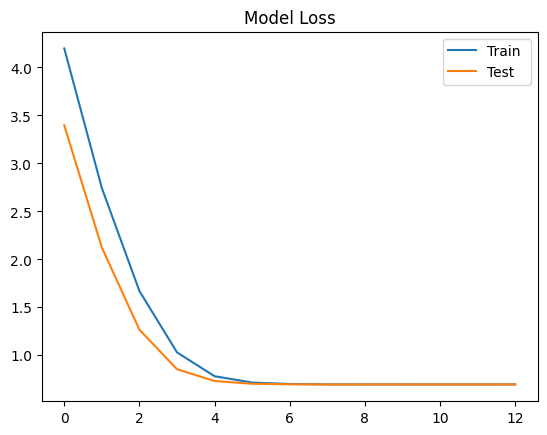

In [35]:
# plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train ')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.legend()
plt.show()

